###  Yusuf Demir 2210356074

## 1. Implementing a CNN from Scratch

#### Brief Overview of the Task 
The goal of this task is to build a Convolutional Neural Network (CNN) model from scratch to classify images of foods into one of eleven categories. This process involves designing and training a custom CNN, evaluating its performance on validation and test sets, and understanding the benefits and challenges of using CNNs for image classification tasks. In the second part, we will also implement transfer learning using a pre-trained CNN (e.g., MobileNetV2/V3 or ShuffleNetV2).

#### What are the main components of a CNN architecture?
1. **Convolutional Layers**: Apply filters to extract local features from the image.
2. **Activation Functions**: Add non-linearity to the network (e.g., ReLU).
3. **Pooling Layers**: Reduce spatial dimensions while preserving essential features.
4. **Fully Connected Layers**: Connect high-level abstract features to the output layer.
5. **Output Layer**: Produces class probabilities using Softmax activation.

#### Why do we use CNNs in image classification?
CNNs automatically learn relevant features, utilize spatial hierarchies effectively, and require fewer parameters than fully connected networks due to weight sharing in convolutional layers.

#### Description of the Dataset
The dataset used for this task is **Food-11**, which contains ~2750 images from 11 food categories:
1. Apple Pie
2. Cheesecake
3. Chicken Curry
4. French Fries
5. Fried Rice
6. Hamburger
7. Hot Dog
8. Ice Cream
9. Omelette
10. Pizza
11. Sushi

- Each class is stored in its own folder containing JPEG images.
- The dataset is split into `train`, `validation`, and `test` folders.
- Images will be resized to 256x256 pixels and normalized using ImageNet statistics:
  - **mean** = `[0.485, 0.456, 0.406]`
  - **std** = `[0.229, 0.224, 0.225]`

Normalization improves training stability, speeds up convergence, and ensures compatibility with pre-trained models used in the transfer learning stage.

### 1.2. Data Loading and Preprocessing (3 points)

In [23]:
# Import necessary libraries
import os
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
from sklearn.metrics import ConfusionMatrixDisplay
import copy
from torchvision import models

In [24]:
# Check if CUDA is available for GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [25]:
def save_model(model, model_name, save_dir="saved_models"):
    """
    Save the trained model to the specified path.
    
    Args:
        model (torch.nn.Module): The trained model to be saved.
        model_name (str): A name for the model file (e.g., "resnet18_fc_only").
        save_path (str): Directory path where the model will be saved (default: current directory).
    """
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"{model_name}")
    torch.save(model.state_dict(), f"{save_path}.pth")
    print(f"Model {model_name} saved at {save_path}.pth")

# model.load_state_dict(torch.load("saved_models/best_finetuned.pth"))
# model.eval() 

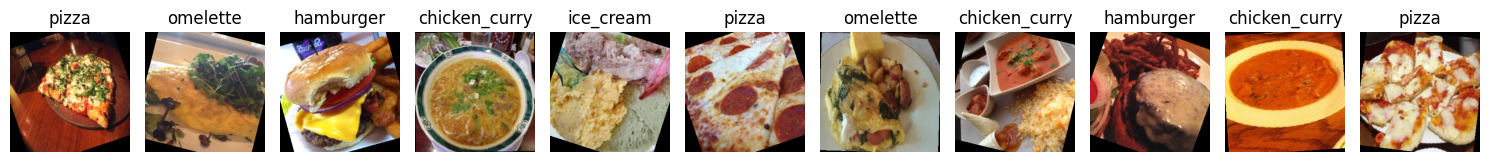

In [ ]:
# Load the dataset
data_dir = "/kaggle/input/food11/food11"  # Update this path to your dataset location

train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "validation")
test_dir = os.path.join(data_dir, "test")

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load datasets from folders
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Class names
class_names = train_dataset.classes

# Sample visualization function
def visualize_samples(loader, class_names, n_samples=11):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images = images[:n_samples]
    labels = labels[:n_samples]

    fig, axes = plt.subplots(1, n_samples, figsize=(15, 5))
    for idx, (image, label) in enumerate(zip(images, labels)):
        image = image.permute(1, 2, 0).numpy()
        image = (image * np.array(std)) + np.array(mean)  # De-normalize
        image = np.clip(image, 0, 1)
        axes[idx].imshow(image)
        axes[idx].set_title(class_names[label])
        axes[idx].axis("off")
    plt.tight_layout()
    plt.show()

# Visualize training samples
visualize_samples(train_loader, class_names)


### 1.3. Define CNN architecture 

#### Reason Behind the Architecture
The architecture is designed to extract hierarchical features from food images (e.g., textures of fried rice, shapes of burgers) while progressively reducing spatial dimensions. By combining convolutional layers, activation functions, pooling, and batch normalization, the network captures both local and global visual patterns. The fully connected layers at the end translate these learned features into class scores for the 11 food categories.

#### Choice of Activation Functions
The ReLU (Rectified Linear Unit) activation function is chosen because:

- It introduces non-linearity, which is essential for learning complex patterns.
- It is computationally efficient and helps mitigate the vanishing gradient problem, facilitating faster convergence during training.

In [27]:
import torch.nn as nn

# CNN architecture without residual connections for Food-11 classification
class FoodClassifierCNN(nn.Module):
    def __init__(self, num_classes=11):
        super(FoodClassifierCNN, self).__init__()

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            self.relu,
            self.pool
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.relu,
            self.pool
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            self.relu,
            self.pool
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            self.relu,
            self.pool
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            self.relu,
            self.pool
        )

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512 * 8 * 8, 1024)  # 256x256 -> 8x8 after 5 pools
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Instantiate and move to device
model = FoodClassifierCNN(num_classes=11).to(device)
print(model)

FoodClassifierCNN(
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (co

## CNN Architecture with Residual Connections

Residual connections (also known as skip connections) help mitigate the vanishing gradient problem in deep neural networks. Instead of learning the full transformation, the model learns the residual (difference) between the input and output of a block, allowing gradients to flow more easily during backpropagation.

In this model, we apply residual connections across certain convolutional blocks to improve convergence and generalization. These skip connections allow the model to bypass one or more layers, helping it retain low-level information and making optimization easier, especially for deeper networks.

In [28]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResidualBlock, self).__init__()
        
        stride = 2 if downsample else 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample
        self.residual_connection = nn.Sequential()

        if downsample or in_channels != out_channels:
            self.residual_connection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.residual_connection(x)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = self.relu(out)
        return out

In [29]:
class FoodClassifierRes(nn.Module):
    def __init__(self, num_classes=11):
        super(FoodClassifierRes, self).__init__()
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Initial convolution (like stem layer)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Residual blocks (5 convolutional layers in total)
        self.res1 = ResidualBlock(32, 64, downsample=True)
        self.res2 = ResidualBlock(64, 128, downsample=True)
        self.res3 = ResidualBlock(128, 256, downsample=True)
        self.res4 = ResidualBlock(256, 512, downsample=True)

        # FC layers
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512 * 8 * 8, 1024)  # After 5 pooling ops on 256x256
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
    
model_residual = FoodClassifierRes(num_classes=11).to(device)
print(model_residual)

FoodClassifierRes(
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): ResidualBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (residual_connection): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (r

### Training the CNN with Residual Connections

To evaluate the effectiveness of residual connections, we trained a second CNN model with residual blocks. The training setup, loss function (CrossEntropyLoss), optimizer (Adam), and scheduler (ReduceLROnPlateau) were kept consistent with the previous non-residual model to ensure a fair comparison.

We experimented with three different learning rates (0.001, 0.0005, 0.0001) and two batch sizes (32, 64). For each configuration, the model was trained for 50 epochs as specified in the assignment. The training and validation loss and accuracy were recorded and plotted to assess performance trends.

This process helped determine the impact of residual connections on training stability, convergence rate, and generalization performance.

In [30]:
def train_model(model, train_loader, val_loader, num_epochs=50, lr=0.001, weight_decay=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []

    best_val_acc = -1
    best_model_state = None

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_accuracy)

        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_accuracy)

        print(f"Train Acc: {train_accuracy:.4f} | Val Acc: {val_accuracy:.4f}")
        scheduler.step(avg_val_loss)

        # Save best model based on validation accuracy
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_state = copy.deepcopy(model.state_dict())

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history, best_model_state

In [31]:
# Grid of hyperparameters
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [32, 64]
num_epochs = 50

In [32]:
# Classic CNN (without residuals)
results_classic = {}

for lr in learning_rates:
    for bs in batch_sizes:
        print(f"\nTraining baseline CNN - LR={lr}, Batch Size={bs}")

        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

        model = FoodClassifierCNN(num_classes=11).to(device)

        train_loss, val_loss, train_acc, val_acc, best_state = train_model(
            model, train_loader, val_loader, num_epochs=num_epochs, lr=lr
        )

        config_name = f"lr={lr}_bs={bs}"
        results_classic[config_name] = {
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'model': copy.deepcopy(model),
            'best_state': best_state
        }


Training baseline CNN - LR=0.001, Batch Size=32


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50
Train Acc: 0.0995 | Val Acc: 0.1055
Epoch 2/50
Train Acc: 0.1214 | Val Acc: 0.1200
Epoch 3/50
Train Acc: 0.1186 | Val Acc: 0.1636
Epoch 4/50
Train Acc: 0.1177 | Val Acc: 0.1418
Epoch 5/50
Train Acc: 0.1345 | Val Acc: 0.1527
Epoch 6/50
Train Acc: 0.1309 | Val Acc: 0.1891
Epoch 7/50
Train Acc: 0.1436 | Val Acc: 0.1455
Epoch 8/50
Train Acc: 0.1523 | Val Acc: 0.1527
Epoch 9/50
Train Acc: 0.1545 | Val Acc: 0.1745
Epoch 10/50
Train Acc: 0.1591 | Val Acc: 0.1745
Epoch 11/50
Train Acc: 0.1436 | Val Acc: 0.1527
Epoch 12/50
Train Acc: 0.1568 | Val Acc: 0.1855
Epoch 13/50
Train Acc: 0.1532 | Val Acc: 0.1927
Epoch 14/50
Train Acc: 0.1568 | Val Acc: 0.1927
Epoch 15/50
Train Acc: 0.1655 | Val Acc: 0.2073
Epoch 16/50
Train Acc: 0.1636 | Val Acc: 0.1636
Epoch 17/50
Train Acc: 0.1691 | Val Acc: 0.1673
Epoch 18/50
Train Acc: 0.1755 | Val Acc: 0.1891
Epoch 19/50
Train Acc: 0.1532 | Val Acc: 0.2436
Epoch 20/50
Train Acc: 0.1827 | Val Acc: 0.2145
Epoch 21/50
Train Acc: 0.1814 | Val Acc: 0.2182
E

In [33]:
# Save history for each config
results = {}

for lr in learning_rates:
    for bs in batch_sizes:
        print(f"\nTraining with LR={lr}, Batch Size={bs}")

        # DataLoaders with current batch size
        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

        # Initialize model fresh each time
        model = FoodClassifierRes(num_classes=11).to(device)

        # Train
        train_loss, val_loss, train_acc, val_acc, best_state = train_model(
            model, train_loader, val_loader, num_epochs=num_epochs, lr=lr
        )

        # Save results
        config_name = f"lr={lr}_bs={bs}"
        results[config_name] = {
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'model': copy.deepcopy(model),
            'best_state': best_state
        }


Training with LR=0.001, Batch Size=32
Epoch 1/50
Train Acc: 0.1014 | Val Acc: 0.1164
Epoch 2/50
Train Acc: 0.1445 | Val Acc: 0.1345
Epoch 3/50
Train Acc: 0.1695 | Val Acc: 0.1927
Epoch 4/50
Train Acc: 0.1809 | Val Acc: 0.1927
Epoch 5/50
Train Acc: 0.2159 | Val Acc: 0.1964
Epoch 6/50
Train Acc: 0.2118 | Val Acc: 0.2073
Epoch 7/50
Train Acc: 0.2305 | Val Acc: 0.2291
Epoch 8/50
Train Acc: 0.2527 | Val Acc: 0.2764
Epoch 9/50
Train Acc: 0.2741 | Val Acc: 0.2800
Epoch 10/50
Train Acc: 0.2764 | Val Acc: 0.2618
Epoch 11/50
Train Acc: 0.2795 | Val Acc: 0.2655
Epoch 12/50
Train Acc: 0.2964 | Val Acc: 0.2836
Epoch 13/50
Train Acc: 0.3018 | Val Acc: 0.2945
Epoch 14/50
Train Acc: 0.3205 | Val Acc: 0.2945
Epoch 15/50
Train Acc: 0.3405 | Val Acc: 0.3564
Epoch 16/50
Train Acc: 0.3314 | Val Acc: 0.3455
Epoch 17/50
Train Acc: 0.3627 | Val Acc: 0.3273
Epoch 18/50
Train Acc: 0.3727 | Val Acc: 0.3455
Epoch 19/50
Train Acc: 0.3814 | Val Acc: 0.3273
Epoch 20/50
Train Acc: 0.3914 | Val Acc: 0.3818
Epoch 21/5

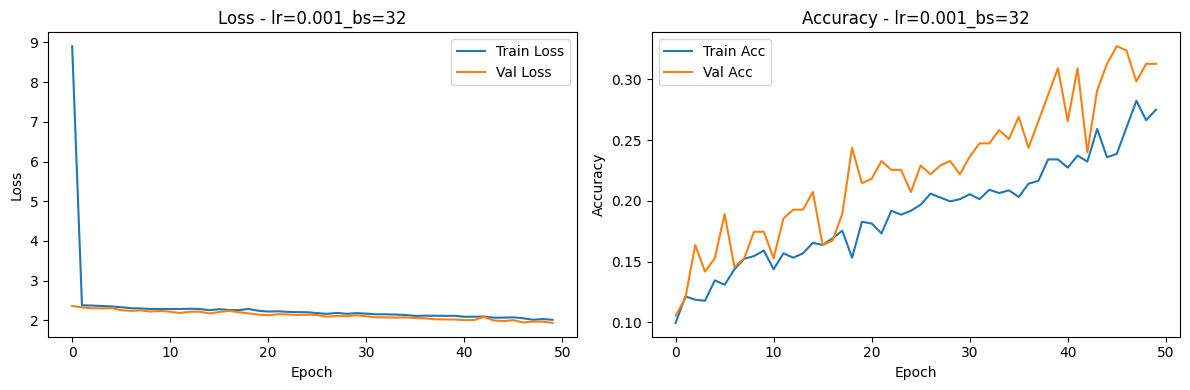

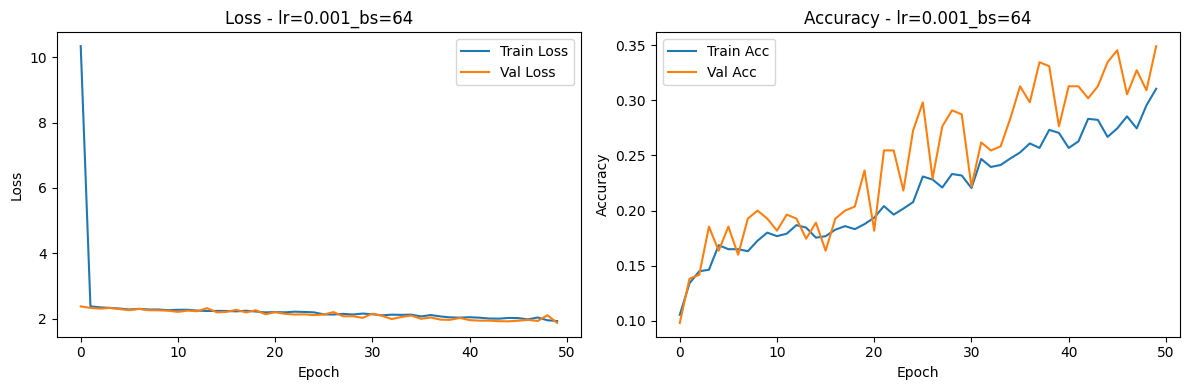

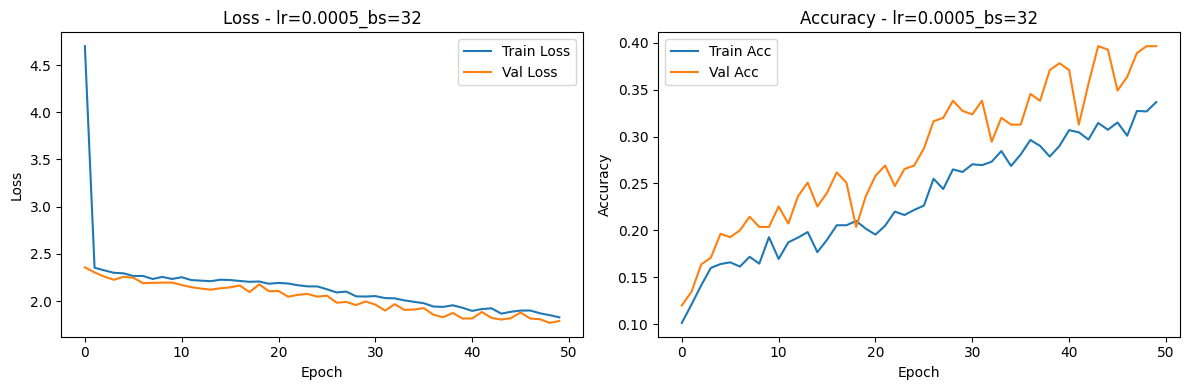

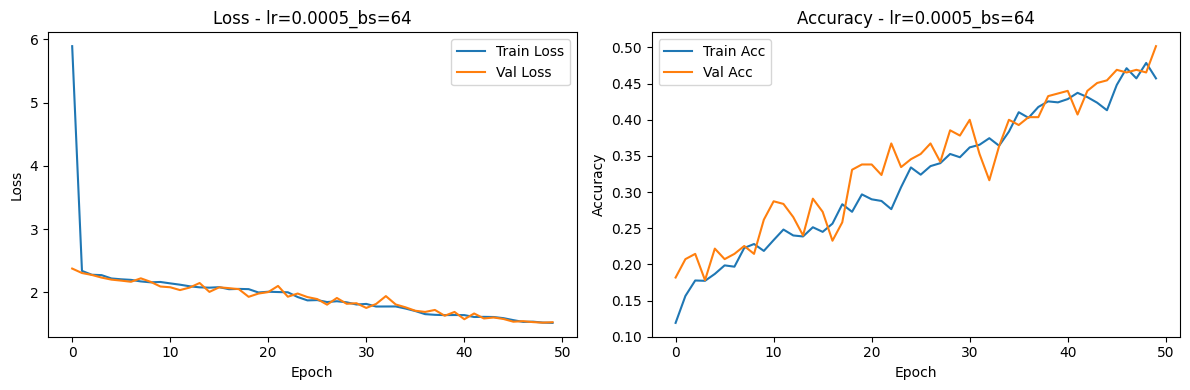

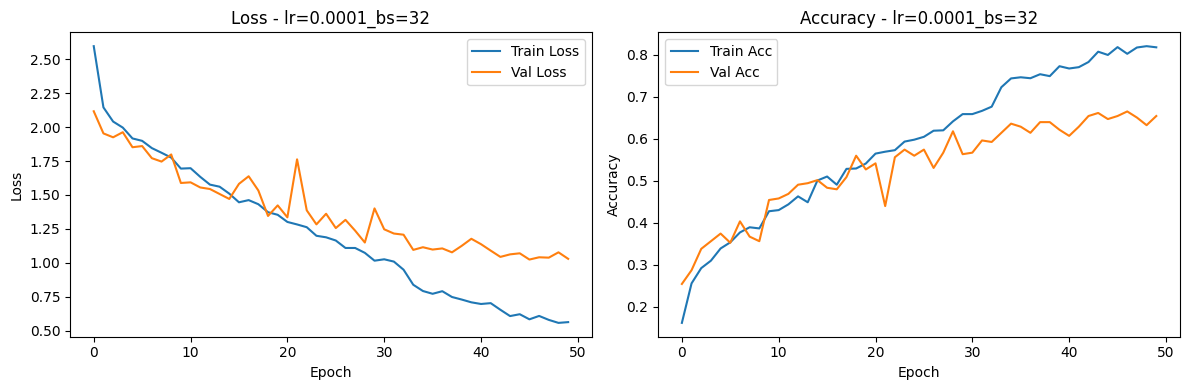

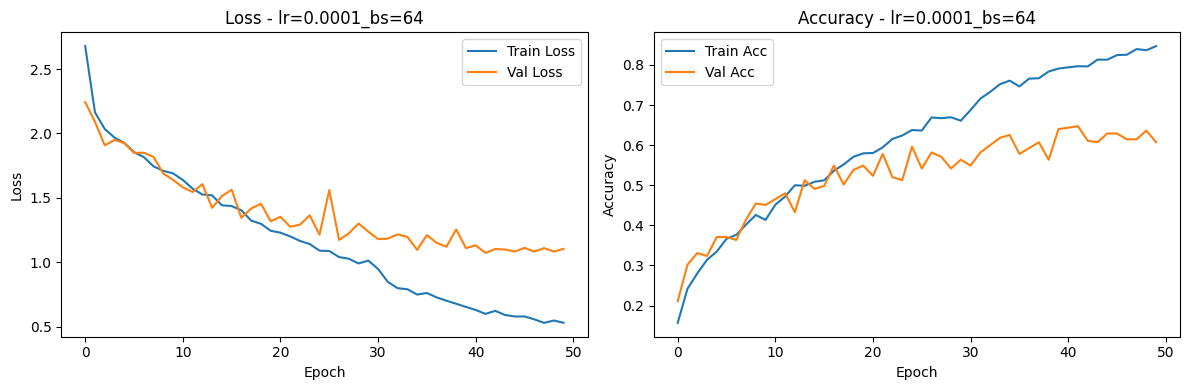

In [34]:
# Plotting results
for config, history in results_classic.items():
    plt.figure(figsize=(12, 4))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f"Loss - {config}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title(f"Accuracy - {config}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

### Evaluation of Classic CNN Training Results

In this section, we analyze the performance of the Classic CNN architecture trained with different learning rates and batch sizes. We evaluated 6 configurations using 3 learning rates (0.001, 0.0005, 0.0001) and 2 batch sizes (32, 64).

#### Learning Rate = 0.001

- **Batch Size = 32**: Training and validation accuracy stayed around 30%. The model learned slowly and showed early stagnation.
- **Batch Size = 64**: Slightly better results than with batch size 32. Validation accuracy reached ~35%, but the model still failed to generalize well.

#### Learning Rate = 0.0005

- **Batch Size = 32**: The model improved steadily, and validation accuracy reached ~39%. This configuration offered a good balance between learning speed and stability.
- **Batch Size = 64**: This was the best-performing configuration. Validation accuracy reached ~50%. The training and validation curves were close, indicating good generalization and no major overfitting.

#### Learning Rate = 0.0001

- **Batch Size = 32**: Training accuracy increased up to ~82%, while validation accuracy plateaued around 66%. This shows mild overfitting, but the validation accuracy was the highest among all classic configurations.
- **Batch Size = 64**: Similar trend to bs=32, with even higher training accuracy (~85%) but no gain in validation accuracy. Generalization did not improve beyond a certain point.

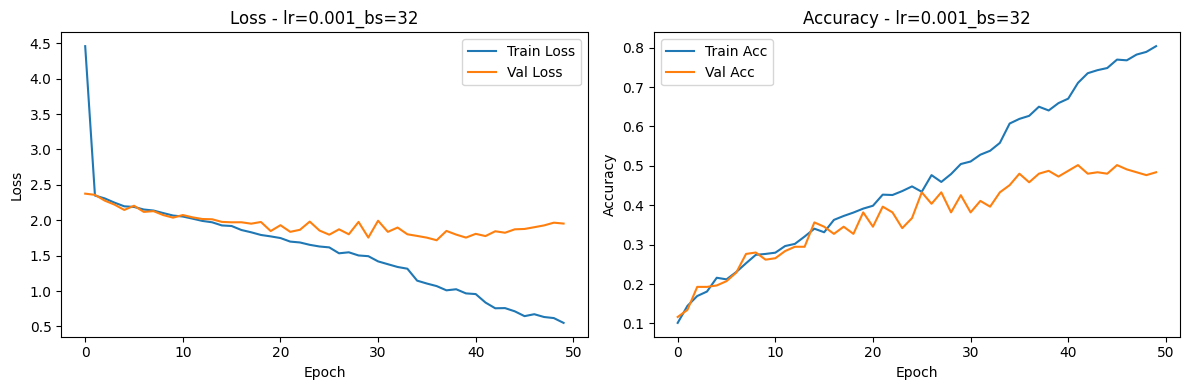

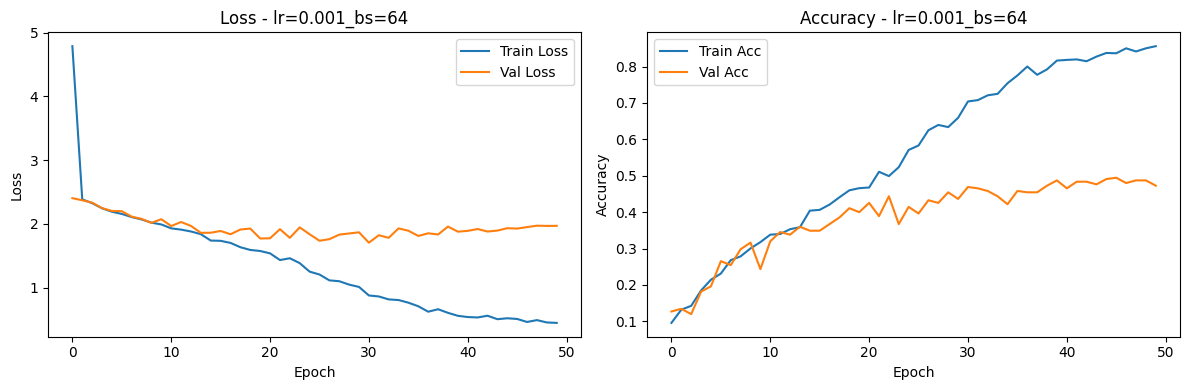

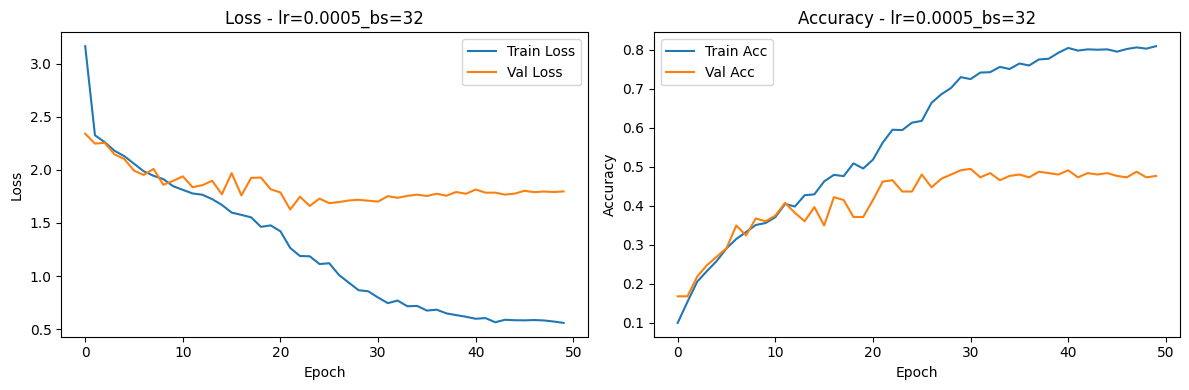

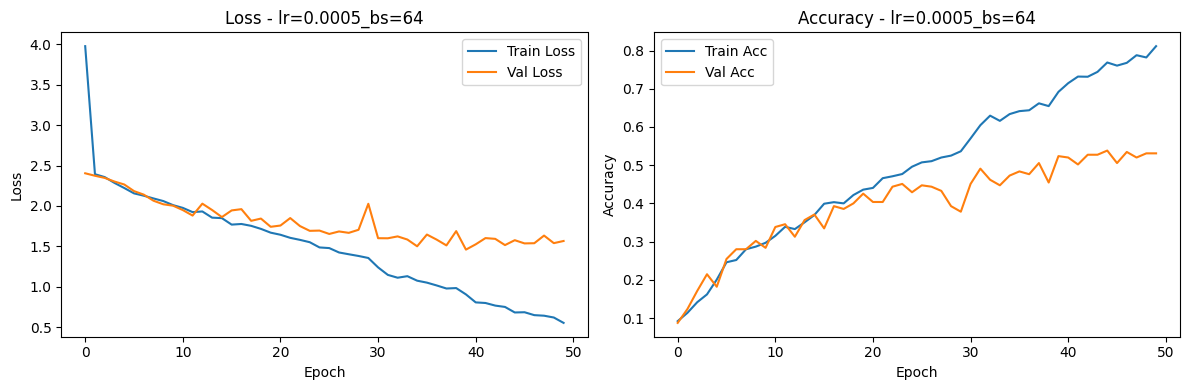

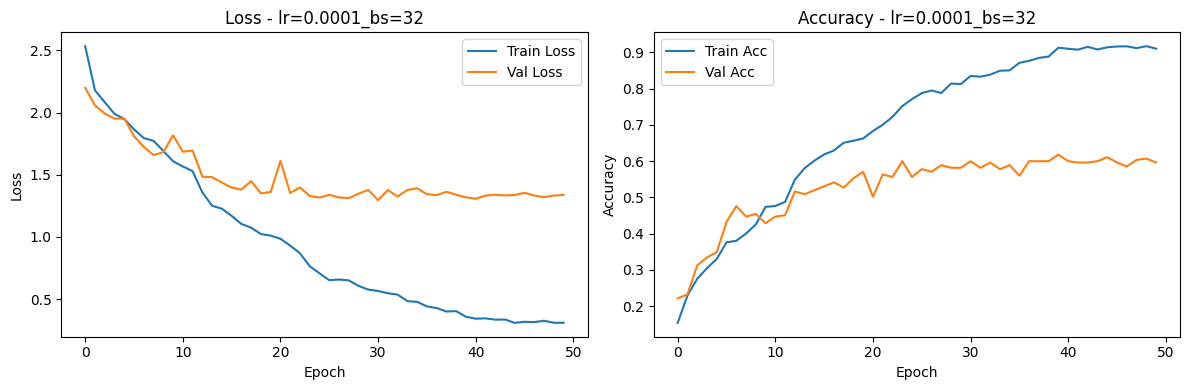

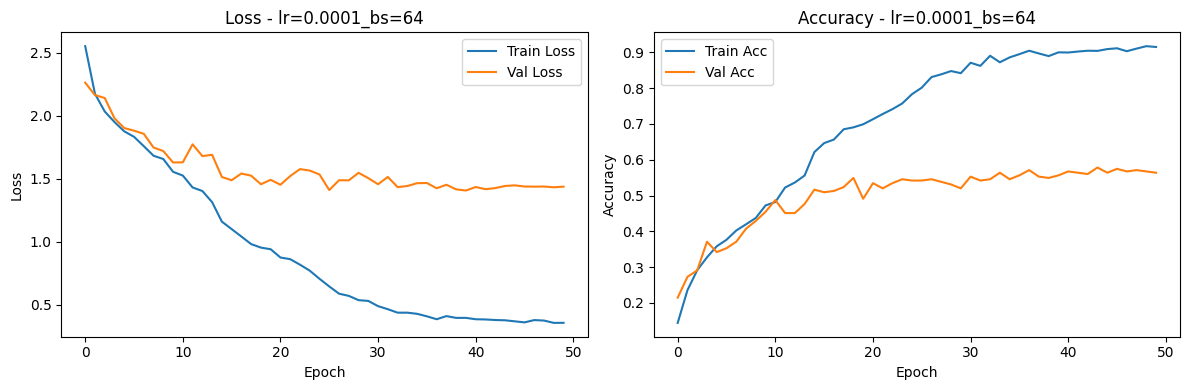

In [35]:
# Plotting results
for config, history in results.items():
    plt.figure(figsize=(12, 4))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f"Loss - {config}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title(f"Accuracy - {config}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

### Evaluation of Residual CNN Training Results

In this section, we analyze the performance of the Residual CNN architecture trained with different learning rates and batch sizes. We evaluated 6 configurations using 3 learning rates (0.001, 0.0005, 0.0001) and 2 batch sizes (32, 64).

#### Learning Rate = 0.001

- **Batch Size = 32**: Training accuracy increased significantly, but validation accuracy saturated around 48%. The widening gap between training and validation curves indicates overfitting.
- **Batch Size = 64**: Performance was similar to bs=32. Validation accuracy again reached ~48% but didn't improve after 30 epochs. Overfitting appeared earlier.

#### Learning Rate = 0.0005

- **Batch Size = 32**: The model reached around 49% validation accuracy, showing moderate improvement over previous configurations. However, a gap between train and validation curves suggested overfitting in later epochs.
- **Batch Size = 64**: Slight improvement in stability. Validation accuracy stabilized around 50%, with better generalization than bs=32.

#### Learning Rate = 0.0001

- **Batch Size = 32**: Training and validation curves showed steady learning. Validation accuracy reached around 55%, and overfitting was less severe.
- **Batch Size = 64**: This configuration achieved the best result. Validation accuracy peaked at ~57%. The model trained consistently with smaller gap between training and validation, indicating good generalization.

### Comparison of Classic CNN and Residual CNN Models

In this section, we compare the performance of Classic CNN and Residual CNN across different configurations to understand the impact of using residual connections.

#### Overall Best Configurations

- **Classic CNN Best Config**: Learning rate = 0.0001, Batch size = 32 → Validation Accuracy ≈ 66%
- **Residual CNN Best Config**: Learning rate = 0.0001, Batch size = 64 → Validation Accuracy ≈ 57%

#### Observations

- **Validation Accuracy**: Despite stronger generalization by residual models, the classic CNN with lr=0.0001 and bs=32 achieved the highest validation accuracy (66%). However, this configuration also showed mild overfitting as training accuracy was significantly higher.
- **Best Performance Trade-off**: While the residual CNN was more robust across learning rates and batch sizes, the classic CNN achieved the best validation accuracy in a specific configuration.

---

### Conclusion

When comparing the overall best-performing configurations, the Classic CNN achieved the highest validation accuracy. However, it also showed signs of overfitting, indicated by a significant gap between training and validation metrics. Residual CNN, on the other hand, offered more stable learning and better generalization across most settings, although it did not outperform Classic CNN in terms of maximum validation accuracy.

In [36]:
def get_best_model(results_dict):
    best_acc = -1
    best_model = None
    best_config = None

    for config, data in results_dict.items():
        max_val_acc = max(data['val_acc'])
        if max_val_acc > best_acc:
            best_acc = max_val_acc
            best_model = copy.deepcopy(data['model'])
            best_model.load_state_dict(data['best_state'])  # direkt en iyi halini yükle
            best_config = config
    return best_model, best_config, best_acc

In [37]:
def evaluate_on_test(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Scoring metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Model cnn_classic_best saved at saved_models/cnn_classic_best.pth
Test Accuracy: 0.5491
Test Precision: 0.5433
Test Recall: 0.5491
Test F1 Score: 0.5383


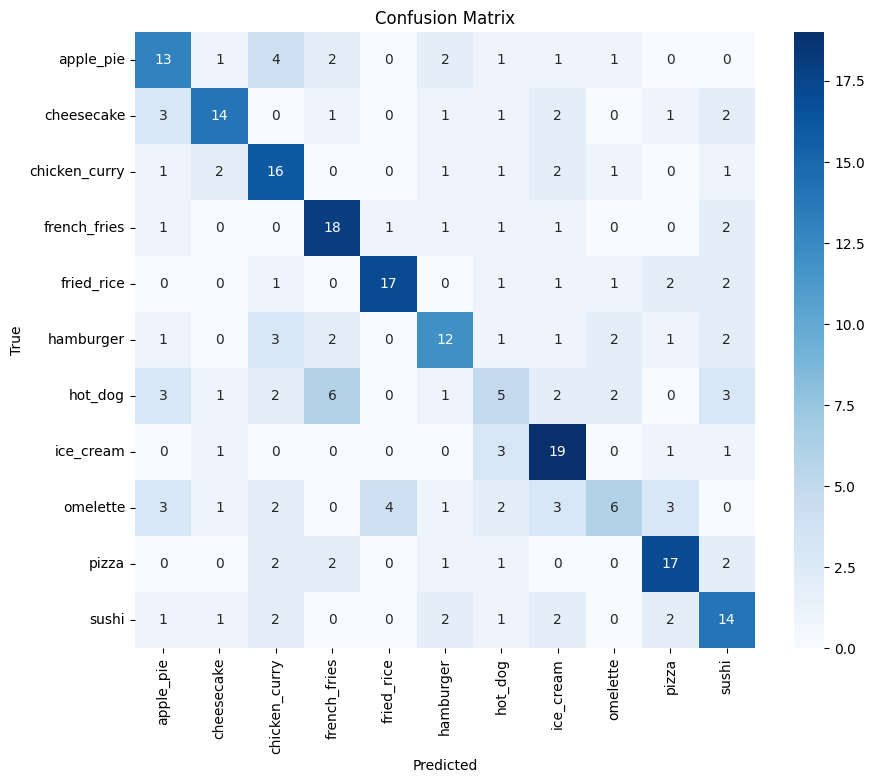

Model cnn_residual_best saved at saved_models/cnn_residual_best.pth
Test Accuracy: 0.5164
Test Precision: 0.5246
Test Recall: 0.5164
Test F1 Score: 0.5122


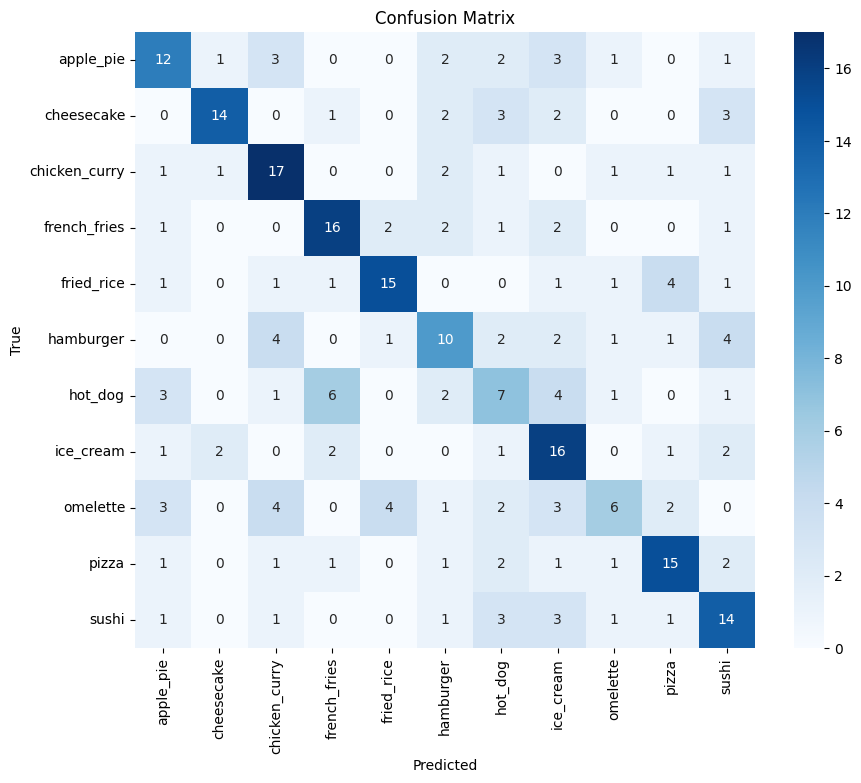

In [38]:
# Best classic model
best_cl_model, best_cl_config, _ = get_best_model(results_classic)
best_cl_model.load_state_dict(results_classic[best_cl_config]['best_state'])
save_model(best_cl_model, "cnn_classic_best")
evaluate_on_test(best_cl_model, test_loader, class_names)

# Best residual model
best_res_model, best_res_config, _ = get_best_model(results)
best_res_model.load_state_dict(results[best_res_config]['best_state'])
save_model(best_res_model, "cnn_residual_best")
evaluate_on_test(best_res_model, test_loader, class_names)

### Dropout

In [39]:
class FoodClassifierCNN(nn.Module):
    def __init__(self, num_classes=11, dropout_rate=0.5):  # yeni parametre
        super(FoodClassifierCNN, self).__init__()

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            self.relu,
            self.pool
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.relu,
            self.pool
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            self.relu,
            self.pool
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            self.relu,
            self.pool
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            self.relu,
            self.pool
        )

        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(512 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [40]:
class FoodClassifierRes(nn.Module):
    def __init__(self, num_classes=11, dropout_rate=0.5):
        super(FoodClassifierRes, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.res1 = ResidualBlock(32, 64, downsample=True)
        self.res2 = ResidualBlock(64, 128, downsample=True)
        self.res3 = ResidualBlock(128, 256, downsample=True)
        self.res4 = ResidualBlock(256, 512, downsample=True)

        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(512 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [41]:
def retrain_with_dropout(base_model_class, dropout_values, train_loader, val_loader, model_name="Model"):
    dropout_results = {}

    for dp in dropout_values:
        print(f"\nTraining {model_name} with Dropout={dp}")
        model = base_model_class(num_classes=11, dropout_rate=dp).to(device)

        train_loss, val_loss, train_acc, val_acc, best_state = train_model(
            model, train_loader, val_loader, num_epochs=num_epochs, lr=0.001
        )

        # Best state'i modele yükleyip kaydet
        model.load_state_dict(best_state)
        save_model(model, f"{model_name}_dropout_{dp}")

        config = f"dropout={dp}"
        dropout_results[config] = {
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'model': copy.deepcopy(model),
            'best_state': best_state
        }

    return dropout_results


Training ClassicCNN with Dropout=0.3


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50
Train Acc: 0.1045 | Val Acc: 0.1164
Epoch 2/50
Train Acc: 0.1145 | Val Acc: 0.1127
Epoch 3/50
Train Acc: 0.1341 | Val Acc: 0.1709
Epoch 4/50
Train Acc: 0.1564 | Val Acc: 0.1673
Epoch 5/50
Train Acc: 0.1709 | Val Acc: 0.1564
Epoch 6/50
Train Acc: 0.1627 | Val Acc: 0.1782
Epoch 7/50
Train Acc: 0.1659 | Val Acc: 0.2036
Epoch 8/50
Train Acc: 0.1795 | Val Acc: 0.1745
Epoch 9/50
Train Acc: 0.1941 | Val Acc: 0.2364
Epoch 10/50
Train Acc: 0.1955 | Val Acc: 0.2255
Epoch 11/50
Train Acc: 0.2045 | Val Acc: 0.1927
Epoch 12/50
Train Acc: 0.2018 | Val Acc: 0.2364
Epoch 13/50
Train Acc: 0.2023 | Val Acc: 0.2291
Epoch 14/50
Train Acc: 0.2145 | Val Acc: 0.2291
Epoch 15/50
Train Acc: 0.2395 | Val Acc: 0.2545
Epoch 16/50
Train Acc: 0.2314 | Val Acc: 0.2691
Epoch 17/50
Train Acc: 0.2464 | Val Acc: 0.2618
Epoch 18/50
Train Acc: 0.2527 | Val Acc: 0.2873
Epoch 19/50
Train Acc: 0.2441 | Val Acc: 0.2836
Epoch 20/50
Train Acc: 0.2495 | Val Acc: 0.3164
Epoch 21/50
Train Acc: 0.2609 | Val Acc: 0.3418
E

/tmp/ipykernel_31/3781955740.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dp_cl_03.load_state_dict(torch.load("saved_models/ClassicCNN_dropout_0.3.pth"))


Test Accuracy: 0.3927
Test Precision: 0.4002
Test Recall: 0.3927
Test F1 Score: 0.3819


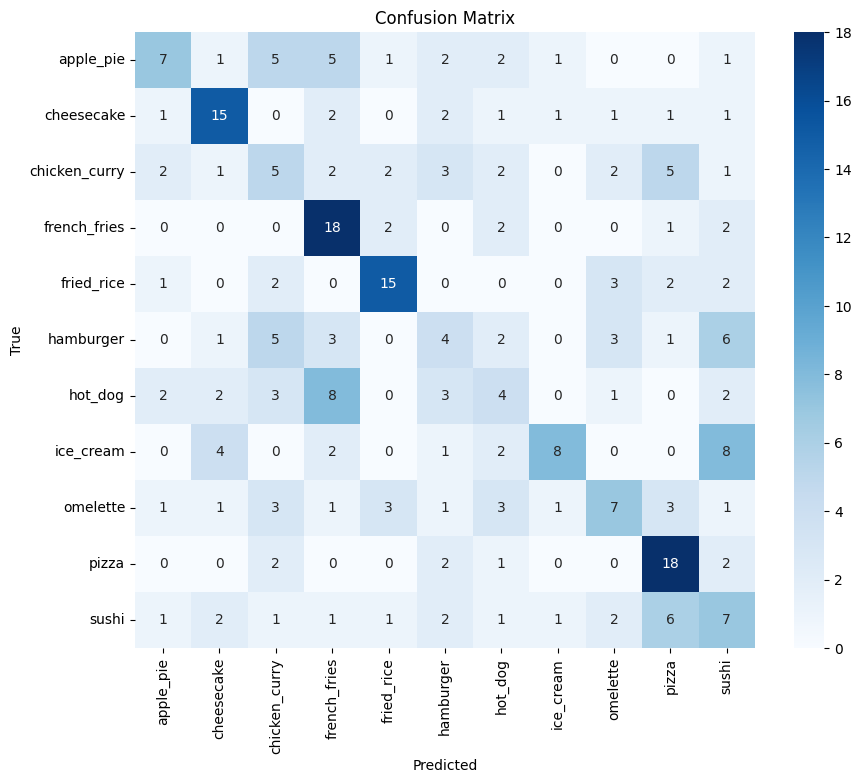

/tmp/ipykernel_31/3781955740.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dp_cl_05.load_state_dict(torch.load("saved_models/ClassicCNN_dropout_0.5.pth"))


Test Accuracy: 0.3091
Test Precision: 0.2969
Test Recall: 0.3091
Test F1 Score: 0.2843


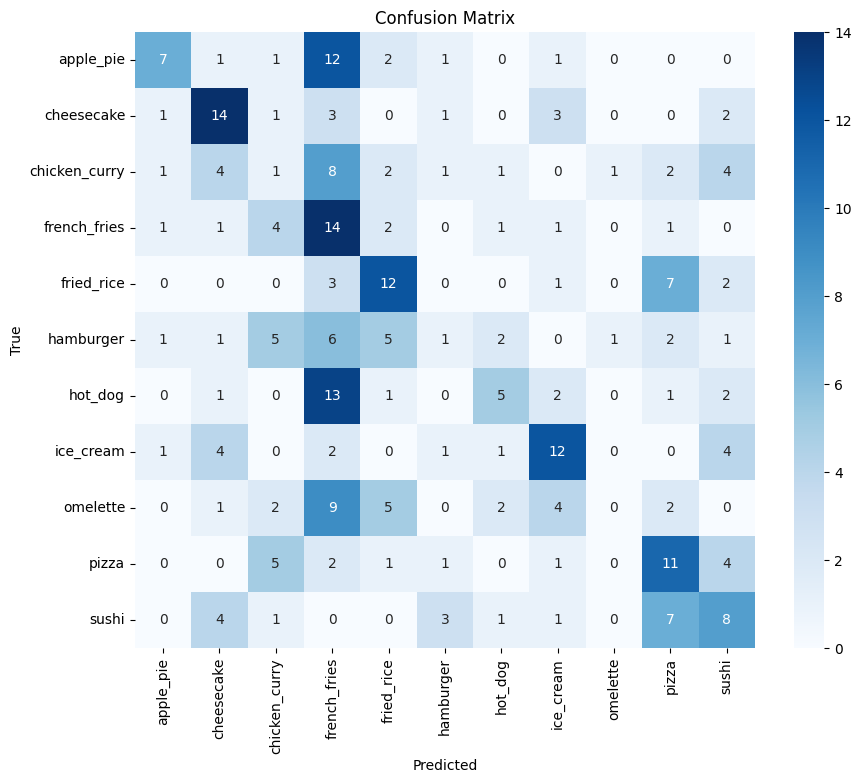

/tmp/ipykernel_31/3781955740.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dp_res_03.load_state_dict(torch.load("saved_models/ResidualCNN_dropout_0.3.pth"))


Test Accuracy: 0.4582
Test Precision: 0.4574
Test Recall: 0.4582
Test F1 Score: 0.4521


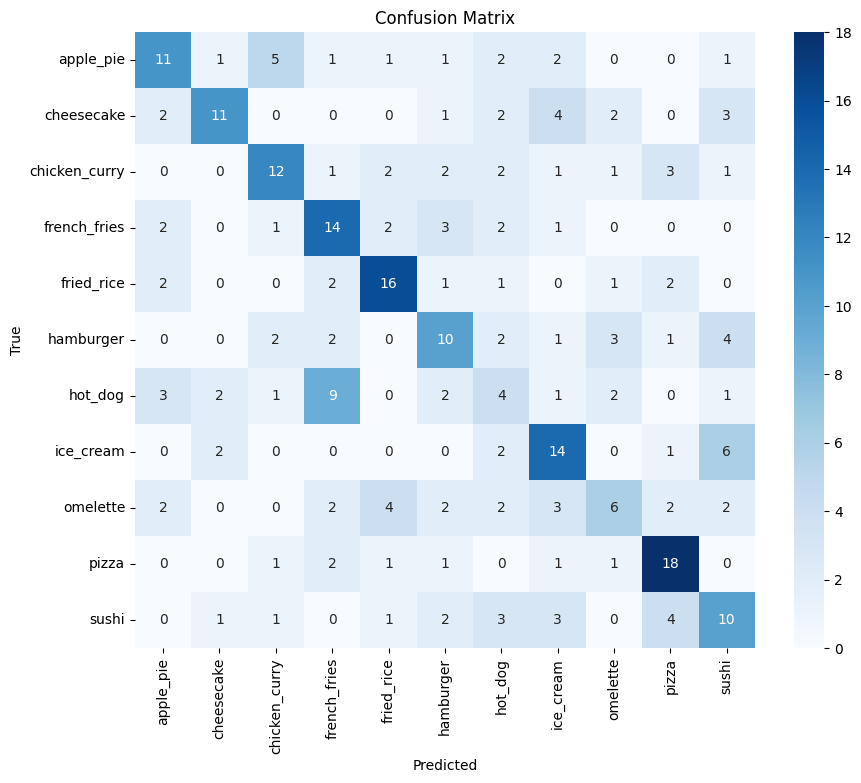

/tmp/ipykernel_31/3781955740.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dp_res_05.load_state_dict(torch.load("saved_models/ResidualCNN_dropout_0.5.pth"))


Test Accuracy: 0.4327
Test Precision: 0.4615
Test Recall: 0.4327
Test F1 Score: 0.4393


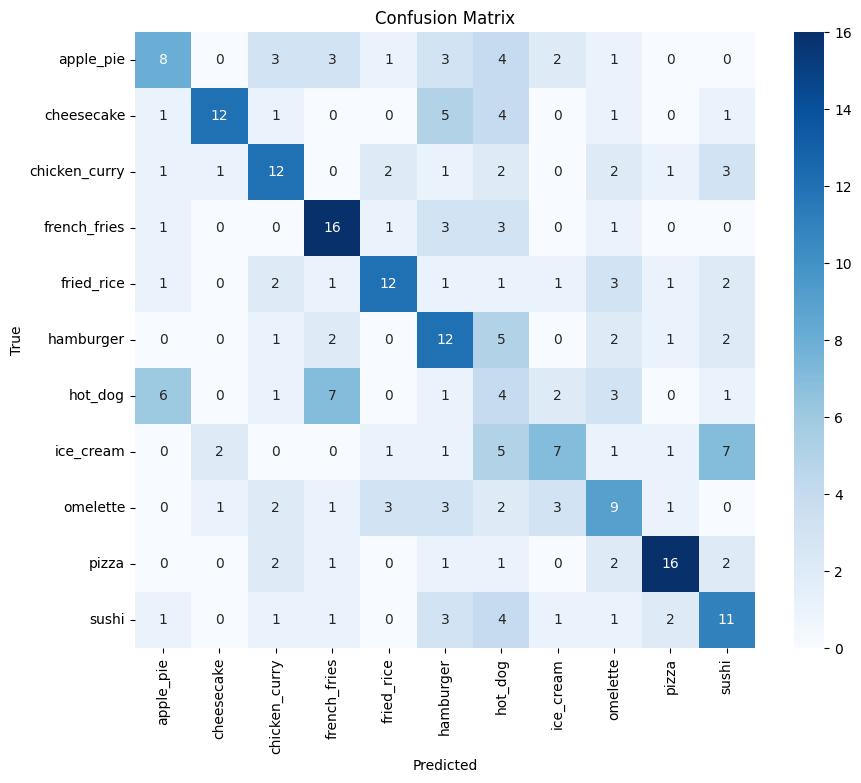

In [42]:
# --- 1. Set up DataLoaders based on best configurations from previous training ---

# 1. Get the best config (batch size) for Classic CNN
_, best_config_cl, _ = get_best_model(results_classic)
best_bs_cl = int(best_config_cl.split("_bs=")[1])
train_loader_cl = DataLoader(train_dataset, batch_size=best_bs_cl, shuffle=True)
val_loader_cl = DataLoader(val_dataset, batch_size=best_bs_cl, shuffle=False)

# 2. Get the best config (batch size) for Residual CNN
_, best_config_res, _ = get_best_model(results)
best_bs_res = int(best_config_res.split("_bs=")[1])
train_loader_res = DataLoader(train_dataset, batch_size=best_bs_res, shuffle=True)
val_loader_res = DataLoader(val_dataset, batch_size=best_bs_res, shuffle=False)

# --- 2. Start dropout training with two values (0.3 and 0.5) for both models ---

dropouts_classic = retrain_with_dropout(
    base_model_class=FoodClassifierCNN,
    dropout_values=[0.3, 0.5],
    train_loader=train_loader_cl,
    val_loader=val_loader_cl,
    model_name="ClassicCNN"
)

dropouts_residual = retrain_with_dropout(
    base_model_class=FoodClassifierRes,
    dropout_values=[0.3, 0.5],
    train_loader=train_loader_res,
    val_loader=val_loader_res,
    model_name="ResidualCNN"
)

# --- 3. Load the best saved dropout models and evaluate them on the test set ---

# ClassicCNN with Dropout=0.3
model_dp_cl_03 = FoodClassifierCNN(num_classes=11, dropout_rate=0.3).to(device)
model_dp_cl_03.load_state_dict(torch.load("saved_models/ClassicCNN_dropout_0.3.pth"))
evaluate_on_test(model_dp_cl_03, test_loader, class_names)

# ClassicCNN with Dropout=0.5
model_dp_cl_05 = FoodClassifierCNN(num_classes=11, dropout_rate=0.5).to(device)
model_dp_cl_05.load_state_dict(torch.load("saved_models/ClassicCNN_dropout_0.5.pth"))
evaluate_on_test(model_dp_cl_05, test_loader, class_names)

# ResidualCNN with Dropout=0.3
model_dp_res_03 = FoodClassifierRes(num_classes=11, dropout_rate=0.3).to(device)
model_dp_res_03.load_state_dict(torch.load("saved_models/ResidualCNN_dropout_0.3.pth"))
evaluate_on_test(model_dp_res_03, test_loader, class_names)

# ResidualCNN with Dropout=0.5
model_dp_res_05 = FoodClassifierRes(num_classes=11, dropout_rate=0.5).to(device)
model_dp_res_05.load_state_dict(torch.load("saved_models/ResidualCNN_dropout_0.5.pth"))
evaluate_on_test(model_dp_res_05, test_loader, class_names)

### Evaluation of Dropout Experiments

In this section, we evaluate the impact of dropout regularization on the performance of both Classic CNN and Residual CNN architectures. Dropout is used to prevent overfitting by randomly deactivating a fraction of neurons during training, which encourages the network to learn more robust and generalized representations.

#### Classic CNN with Dropout

- **Dropout = 0.3**: The model achieved a validation accuracy of ~46% by the end of training. Training accuracy remained lower (~43%), suggesting that the model was successfully regularized and did not overfit. Compared to the best Classic CNN configuration without dropout (~50–66% val acc depending on config), this model performed slightly worse in terms of raw accuracy but demonstrated more stable generalization with narrower train/val gaps.

- **Dropout = 0.5**: Increasing the dropout rate to 0.5 reduced the model's capacity to learn effectively. Validation accuracy only reached ~36%, and training accuracy remained under 30% for much of training. This suggests underfitting, where the model struggled to capture enough patterns due to overly aggressive regularization.

#### Residual CNN with Dropout

- **Dropout = 0.3**: The model performed well, reaching a validation accuracy of ~46%. Training accuracy peaked around 89%, indicating some overfitting but not severe. The performance was slightly below the best non-dropout residual model (~57%), but generalization remained decent and training was stable.

- **Dropout = 0.5**: This configuration provided the best overall result among all dropout experiments. Validation accuracy reached ~49%, very close to the best non-dropout residual result. Training accuracy was also high (~83%), but the gap between training and validation metrics remained moderate. This model achieved a strong balance between regularization and learning capacity.

---

### Conclusion

Dropout regularization helped improve generalization in several configurations, especially for Residual CNN. While dropout=0.3 yielded moderate improvements, dropout=0.5 proved most effective in the residual architecture. In contrast, Classic CNN struggled to benefit from higher dropout, likely due to its shallower structure and limited learning capacity.

In summary:

- **Classic CNN**: Dropout provided some regularization benefits at 0.3, but excessive dropout (0.5) caused underfitting.
- **Residual CNN**: Dropout improved stability and generalization. 

Overall, dropout was more beneficial in deeper models with higher representational capacity, supporting the idea that regularization techniques are more effective when combined with deeper architectures.

In [43]:
# Combine all result dictionaries into a single dictionary
all_part1_results = {
    "classic": results_classic,
    "residual": results,
    "dropout_classic": dropouts_classic,
    "dropout_residual": dropouts_residual
}

overall_best_model = None
overall_best_config = None
overall_best_acc = -1
overall_best_label = ""

# Search through all result sets
for label, result_set in all_part1_results.items():
    model, config, acc = get_best_model(result_set)
    print(f"{label}: {acc:.4f} at {config}")
    
    if acc > overall_best_acc:
        overall_best_model = model
        overall_best_config = config
        overall_best_acc = acc
        overall_best_label = f"{label} ({config})"

# Save the true best model from Part 1 (including dropout candidates)
save_model(overall_best_model, "part1_final_best_model")
print(f"\n📌 Final best model from Part 1: {overall_best_label} with acc {overall_best_acc:.4f}")

classic: 0.6655 at lr=0.0001_bs=32
residual: 0.6182 at lr=0.0001_bs=32
dropout_classic: 0.4582 at dropout=0.3
dropout_residual: 0.4909 at dropout=0.5
Model part1_final_best_model saved at saved_models/part1_final_best_model.pth

📌 Final best model from Part 1: classic (lr=0.0001_bs=32) with acc 0.6655


### Final Evaluation of All Part 1 Models

Based on validation accuracy, the best performing model in Part 1 was the **Classic CNN** trained with a learning rate of `0.0001` and batch size `32`, achieving **66.55%** validation accuracy. Surprisingly, it outperformed both the **Residual CNN** (61.82%) and all **dropout-enhanced models**.

## 2. Exploring Transfer Learning with MobileNetV2

### 2.1. Introduction

In this part, we explore transfer learning using the MobileNetV2 architecture pre-trained on the ImageNet dataset. The aim is to evaluate the effectiveness of using learned features from a general dataset to classify food images in the Food-11 dataset.

**Transfer learning** allows leveraging pre-trained convolutional backbones to reduce training time and improve performance, especially when working with limited data. In our implementation:

- The pre-trained MobileNetV2 model is modified to output predictions for 11 food classes.
- In the first scenario, we **freeze all layers except the final fully connected (FC) layer**.
- In the second scenario, we **unfreeze the last two convolutional blocks and the FC layer**, enabling partial fine-tuning.
- The models are trained for **50 epochs** and evaluated using validation and test datasets.


### 2.2 Modify the MobileNetV2 model for transfer learning 

In [44]:
from torchvision import models

num_classes = 11
criterion = nn.CrossEntropyLoss()

# Case 1: Freeze all layers except FC
def load_mobilenet_fc_only():
    model = models.mobilenet_v2(pretrained=True)
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)

    # Freeze all layers
    for param in model.features.parameters():
        param.requires_grad = False

    return model

# Case 2: Unfreeze last 2 blocks + FC
def load_mobilenet_last_blocks():
    model = models.mobilenet_v2(pretrained=True)
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the last 2 inverted residual blocks
    for param in model.features[14:].parameters():
        param.requires_grad = True

    # Unfreeze classifier
    for param in model.classifier.parameters():
        param.requires_grad = True

    return model

In [45]:
def validate_model(model, val_loader):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_accuracy = correct / total
    return val_loss, val_accuracy

def train_transfer_model(model, train_loader, val_loader, optimizer, num_epochs=50):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_acc = -1
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = correct / total
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        val_loss, val_accuracy = validate_model(model, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        # Save best model state
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_state = copy.deepcopy(model.state_dict())

    return model, {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accuracies,
        'val_acc': val_accuracies,
        'best_state': best_model_state,
        'best_val_acc': best_val_acc
    }

In [46]:
# Data loaders
train_loader_tl = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_tl = DataLoader(val_dataset, batch_size=32, shuffle=False)

# FC only
model_fc = load_mobilenet_fc_only().to(device)
optimizer_fc = optim.Adam(filter(lambda p: p.requires_grad, model_fc.parameters()), lr=0.001)
model_fc, metrics_fc = train_transfer_model(model_fc, train_loader_tl, val_loader_tl, optimizer_fc, num_epochs=num_epochs)
model_fc.load_state_dict(metrics_fc['best_state'])  # Load best weights into the model
save_model(model_fc, "mobilenet_fc_only_best")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 115MB/s] 


Epoch 1/50 - Train Acc: 0.4218, Val Acc: 0.7564
Epoch 2/50 - Train Acc: 0.6759, Val Acc: 0.8218
Epoch 3/50 - Train Acc: 0.7177, Val Acc: 0.8145
Epoch 4/50 - Train Acc: 0.7477, Val Acc: 0.8873
Epoch 5/50 - Train Acc: 0.7523, Val Acc: 0.8655
Epoch 6/50 - Train Acc: 0.7659, Val Acc: 0.8691
Epoch 7/50 - Train Acc: 0.7682, Val Acc: 0.8764
Epoch 8/50 - Train Acc: 0.7836, Val Acc: 0.8691
Epoch 9/50 - Train Acc: 0.7691, Val Acc: 0.8800
Epoch 10/50 - Train Acc: 0.7873, Val Acc: 0.8873
Epoch 11/50 - Train Acc: 0.7868, Val Acc: 0.8800
Epoch 12/50 - Train Acc: 0.7923, Val Acc: 0.8873
Epoch 13/50 - Train Acc: 0.7945, Val Acc: 0.8800
Epoch 14/50 - Train Acc: 0.7955, Val Acc: 0.8764
Epoch 15/50 - Train Acc: 0.7932, Val Acc: 0.8764
Epoch 16/50 - Train Acc: 0.7941, Val Acc: 0.8873
Epoch 17/50 - Train Acc: 0.8123, Val Acc: 0.8836
Epoch 18/50 - Train Acc: 0.8150, Val Acc: 0.8836
Epoch 19/50 - Train Acc: 0.8109, Val Acc: 0.8909
Epoch 20/50 - Train Acc: 0.7968, Val Acc: 0.8764
Epoch 21/50 - Train Acc: 0.80

In [47]:
# Last 2 blocks + FC
model_partial = load_mobilenet_last_blocks().to(device)
optimizer_partial = optim.Adam(filter(lambda p: p.requires_grad, model_partial.parameters()), lr=0.0005)
model_partial, metrics_partial = train_transfer_model(model_partial, train_loader_tl, val_loader_tl, optimizer_partial, num_epochs=num_epochs)
model_partial.load_state_dict(metrics_partial['best_state'])
save_model(model_partial, "mobilenet_last_blocks_best")

Epoch 1/50 - Train Acc: 0.6527, Val Acc: 0.8836
Epoch 2/50 - Train Acc: 0.8027, Val Acc: 0.8509
Epoch 3/50 - Train Acc: 0.8473, Val Acc: 0.8691
Epoch 4/50 - Train Acc: 0.8850, Val Acc: 0.9200
Epoch 5/50 - Train Acc: 0.9218, Val Acc: 0.8982
Epoch 6/50 - Train Acc: 0.9332, Val Acc: 0.8945
Epoch 7/50 - Train Acc: 0.9509, Val Acc: 0.9018
Epoch 8/50 - Train Acc: 0.9473, Val Acc: 0.9273
Epoch 9/50 - Train Acc: 0.9427, Val Acc: 0.8909
Epoch 10/50 - Train Acc: 0.9450, Val Acc: 0.9200
Epoch 11/50 - Train Acc: 0.9636, Val Acc: 0.9164
Epoch 12/50 - Train Acc: 0.9727, Val Acc: 0.9382
Epoch 13/50 - Train Acc: 0.9782, Val Acc: 0.9345
Epoch 14/50 - Train Acc: 0.9700, Val Acc: 0.8982
Epoch 15/50 - Train Acc: 0.9718, Val Acc: 0.8945
Epoch 16/50 - Train Acc: 0.9723, Val Acc: 0.8982
Epoch 17/50 - Train Acc: 0.9695, Val Acc: 0.8873
Epoch 18/50 - Train Acc: 0.9691, Val Acc: 0.9055
Epoch 19/50 - Train Acc: 0.9677, Val Acc: 0.9018
Epoch 20/50 - Train Acc: 0.9695, Val Acc: 0.8909
Epoch 21/50 - Train Acc: 0.97

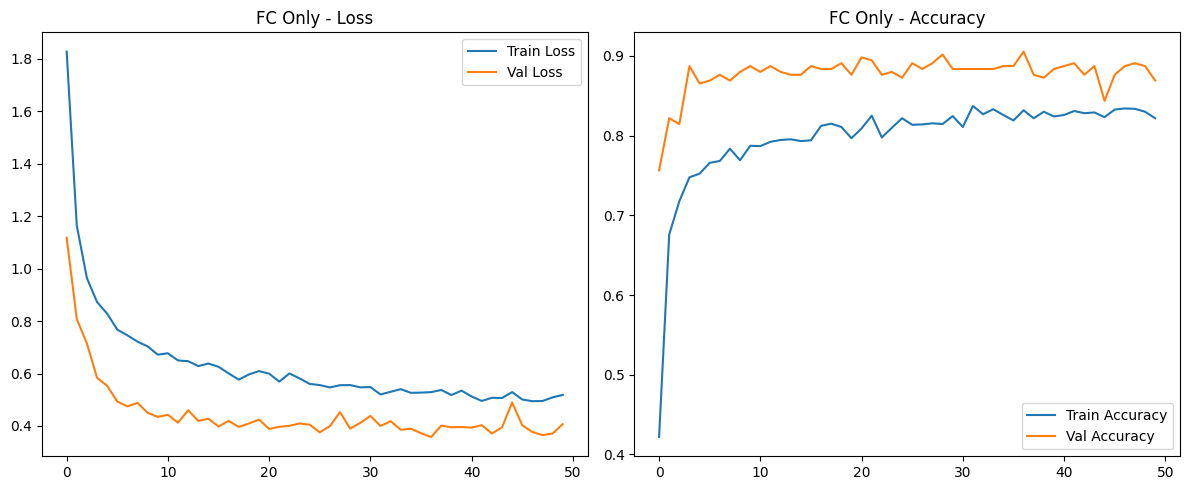

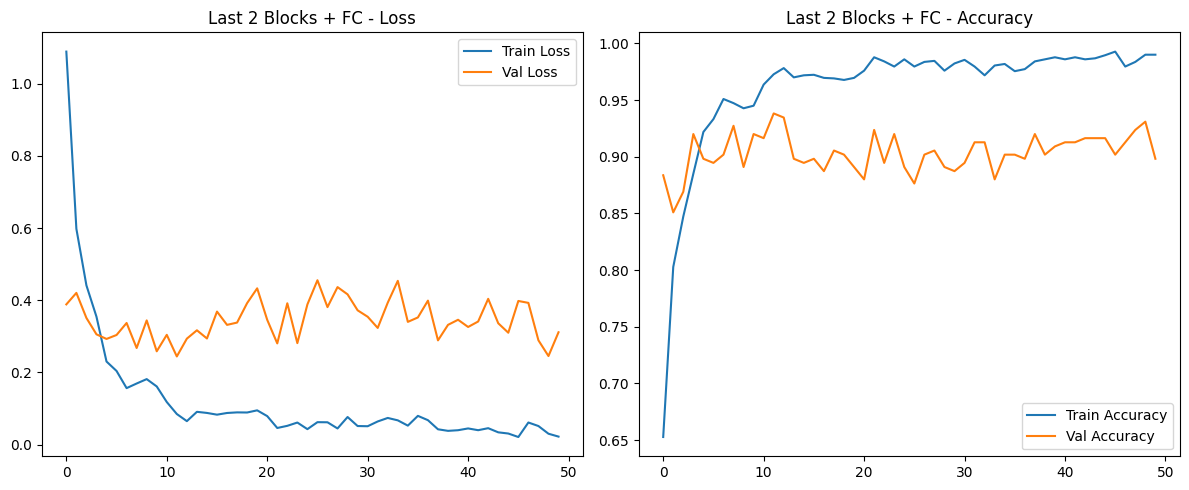

In [48]:
def plot_transfer_results(metrics_dict, label):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(metrics_dict['train_loss'], label='Train Loss')
    plt.plot(metrics_dict['val_loss'], label='Val Loss')
    plt.title(f'{label} - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metrics_dict['train_acc'], label='Train Accuracy')
    plt.plot(metrics_dict['val_acc'], label='Val Accuracy')
    plt.title(f'{label} - Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_transfer_results(metrics_fc, "FC Only")
plot_transfer_results(metrics_partial, "Last 2 Blocks + FC")

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

def evaluate_and_plot_confusion_matrix(model, test_loader, class_names, model_label="Model"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"\nTest Evaluation for {model_label}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model_label}")
    plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_31/3537519718.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for mor


Test Evaluation for MobileNetV2 FC Only
Accuracy:  0.8000
Precision: 0.8073
Recall:    0.8000
F1 Score:  0.8004


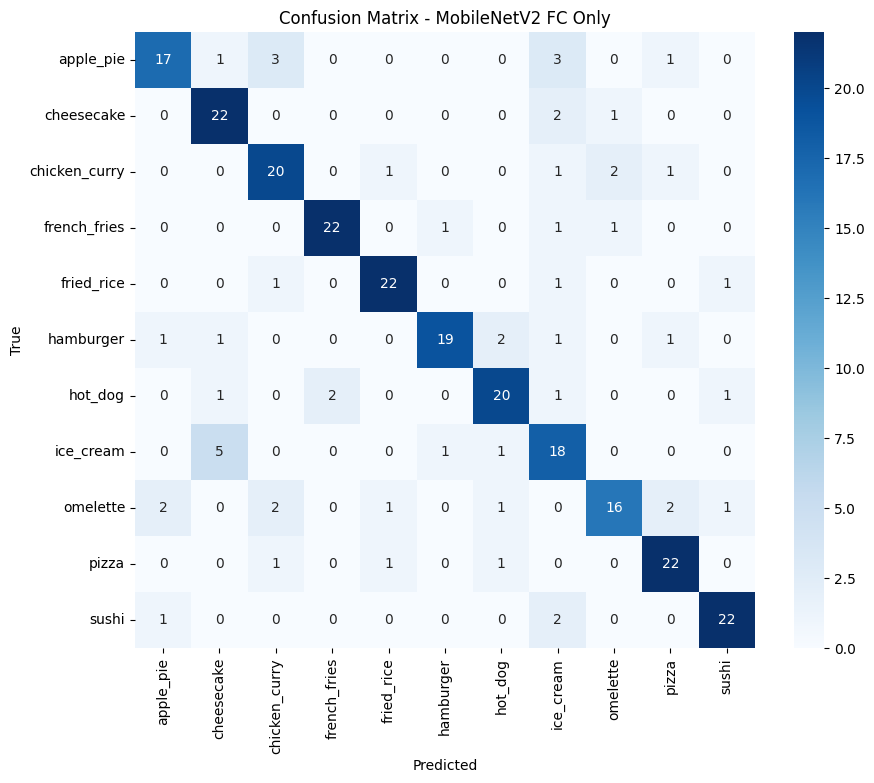

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_31/3537519718.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for mor


Test Evaluation for MobileNetV2 Last 2 Blocks + FC
Accuracy:  0.8582
Precision: 0.8720
Recall:    0.8582
F1 Score:  0.8591


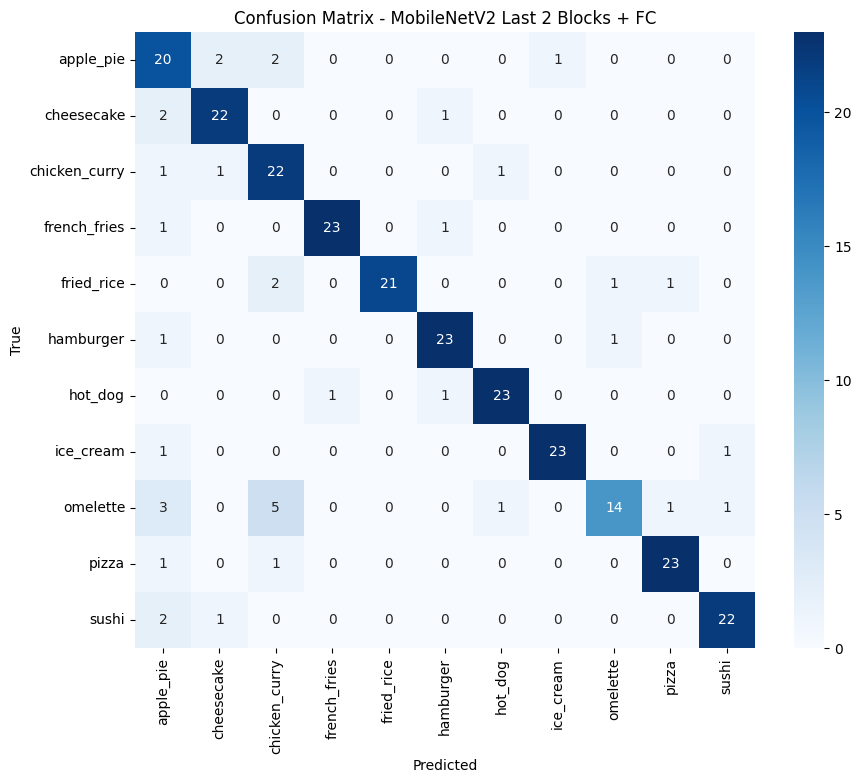

In [56]:
# Load the model and test it
model_fc_best = load_mobilenet_fc_only().to(device)
model_fc_best.load_state_dict(torch.load("saved_models/mobilenet_fc_only_best.pth"))
evaluate_and_plot_confusion_matrix(model_fc_best, test_loader, class_names, model_label="MobileNetV2 FC Only")

model_partial_best = load_mobilenet_last_blocks().to(device)
model_partial_best.load_state_dict(torch.load("saved_models/mobilenet_last_blocks_best.pth"))
evaluate_and_plot_confusion_matrix(model_partial_best, test_loader, class_names, model_label="MobileNetV2 Last 2 Blocks + FC")

### Evaluation of Fine-Tuned Models (Part 2)

In Part 2, we applied transfer learning using MobileNetV2 and compared two fine-tuning strategies:

1. **Fine-tuning only the Fully Connected (FC) layers**
2. **Fine-tuning the last two convolutional blocks + FC layers**

#### FC-Only Fine-Tuning

- **Validation Accuracy**: The model reached around **88–89%** accuracy early and remained consistent throughout training.
- **Training Accuracy**: It gradually increased and plateaued at ~83%, staying slightly below validation accuracy.
- **Generalization**: The validation performance remained stable with a small gap, indicating good generalization and no overfitting.
- **Observation**: This approach is efficient and prevents overfitting by reducing the number of trainable parameters.

#### Last Two Blocks + FC Fine-Tuning

- **Validation Accuracy**: Peaked around **93%**, higher than the FC-only model.
- **Training Accuracy**: Exceeded **98%**, creating a more noticeable gap with validation accuracy.
- **Loss Trends**: Validation loss fluctuated more and did not decrease as smoothly as training loss.
- **Observation**: Although performance improved, signs of overfitting appeared due to higher model complexity.

#### Conclusion

While both models performed well, the **last 2 blocks + FC** approach achieved higher validation accuracy. However, the **FC-only model** showed more stable generalization. Depending on the application and available compute, the FC-only model is a safer and more efficient choice, while deeper fine-tuning offers better performance at the risk of slight overfitting.

/tmp/ipykernel_31/1094391040.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_part1.load_state_dict(torch.load("saved_models/part1_final_best_model.pth"))



Test Evaluation for CNN from Scratch
Accuracy:  0.5491
Precision: 0.5433
Recall:    0.5491
F1 Score:  0.5383


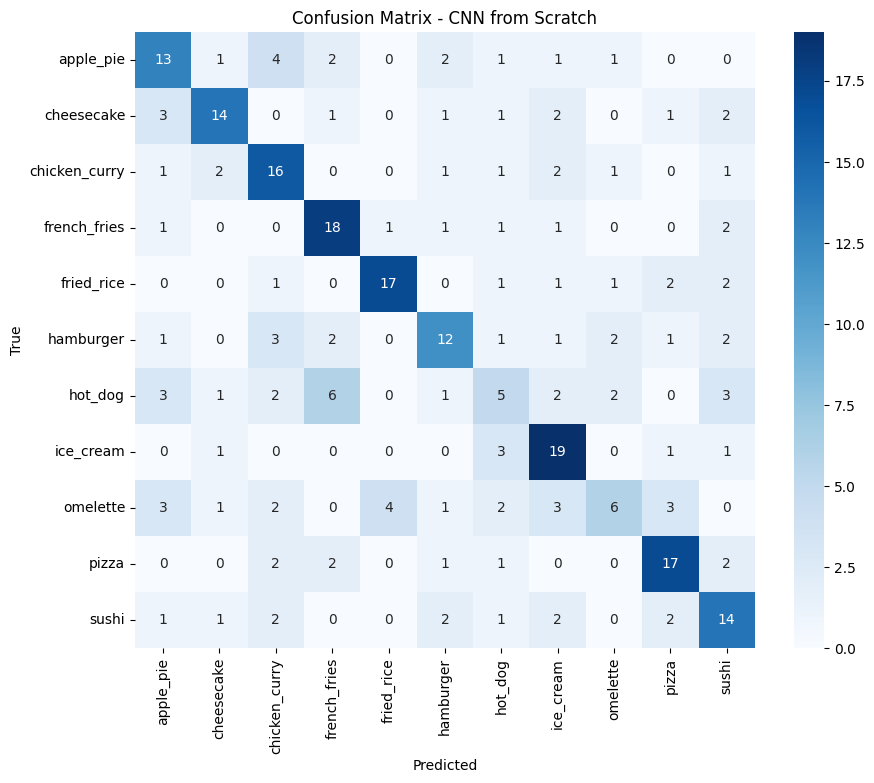

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_31/1094391040.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for mor


Test Evaluation for MobileNetV2 FC Only
Accuracy:  0.8000
Precision: 0.8073
Recall:    0.8000
F1 Score:  0.8004


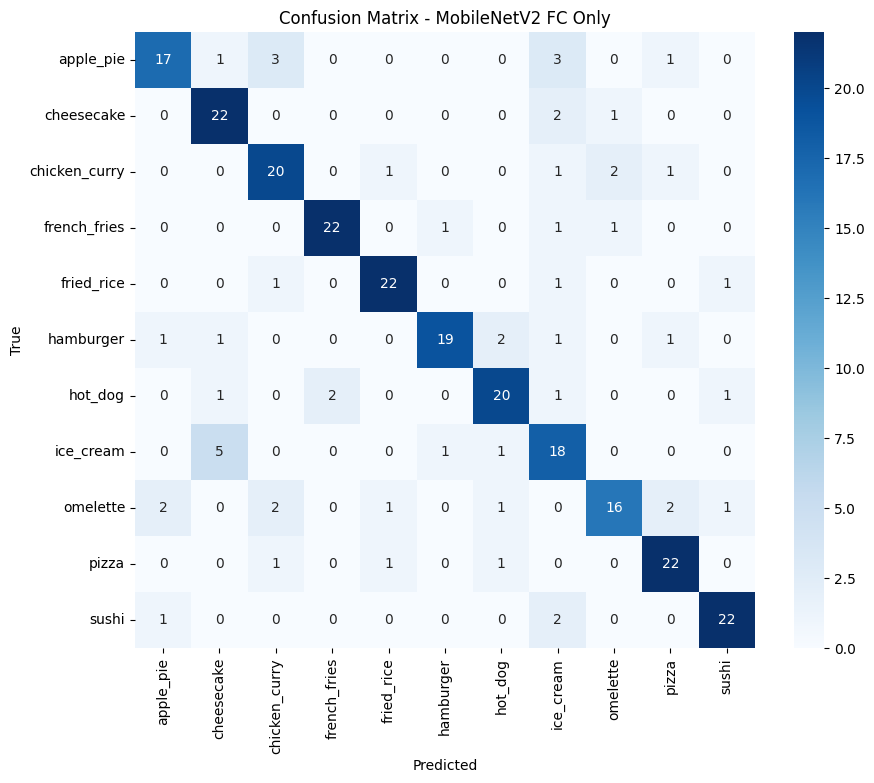

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_31/1094391040.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for mo


Test Evaluation for MobileNetV2 Last 2 Blocks + FC
Accuracy:  0.8582
Precision: 0.8720
Recall:    0.8582
F1 Score:  0.8591


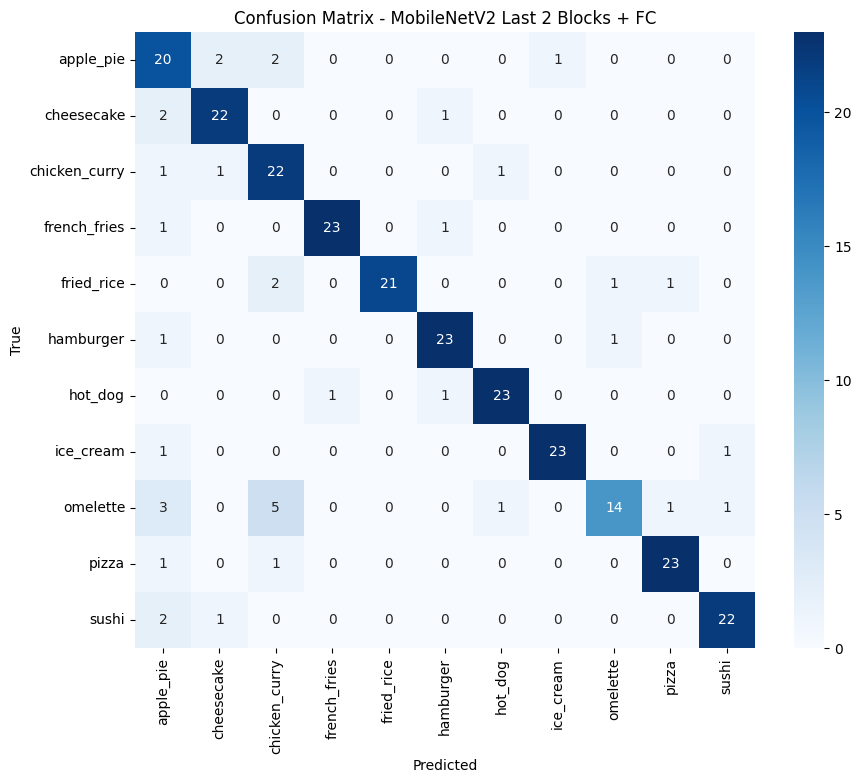

In [57]:
# Part 1 - CNN from scratch
model_part1 = FoodClassifierCNN(num_classes=11).to(device) #* The class here should be updated according to the best model.
model_part1.load_state_dict(torch.load("saved_models/part1_final_best_model.pth"))
evaluate_and_plot_confusion_matrix(model_part1, test_loader, class_names, model_label="CNN from Scratch")

# Part 2 - FC only fine-tuned MobileNet
model_fc = load_mobilenet_fc_only().to(device)
model_fc.load_state_dict(torch.load("saved_models/mobilenet_fc_only_best.pth"))
evaluate_and_plot_confusion_matrix(model_fc, test_loader, class_names, model_label="MobileNetV2 FC Only")

# Part 2 - Last 2 conv blocks + FC fine-tuned MobileNet
model_last_blocks = load_mobilenet_last_blocks().to(device)
model_last_blocks.load_state_dict(torch.load("saved_models/mobilenet_last_blocks_best.pth"))
evaluate_and_plot_confusion_matrix(model_last_blocks, test_loader, class_names, model_label="MobileNetV2 Last 2 Blocks + FC")

## 3 Analyze advantages and disadvantages

### Analysis of Advantages and Disadvantages

#### Transfer Learning

**Advantages:**
- Significantly faster convergence thanks to pre-trained features.
- Performs well even with limited training data.
- High validation accuracy can be achieved with minimal fine-tuning.
- Requires fewer computational resources for initial training.

**Disadvantages:**
- Fine-tuning deeper layers can lead to overfitting if not managed carefully.
- May not fully adapt to highly domain-specific datasets.
- Limited interpretability of learned features due to black-box backbone.

#### Training from Scratch

**Advantages:**
- Full control over architecture and training process.
- Customizable feature extraction specific to the dataset.
- Can outperform transfer learning if sufficient data and training time are available.

**Disadvantages:**
- Requires significantly more data and time to achieve competitive accuracy.
- Higher risk of overfitting or underfitting depending on model capacity.
- Sensitive to hyperparameter choices and initialization.

### Practical Considerations

_When deciding between training from scratch and transfer learning, dataset size and training resources are crucial. In this assignment, models trained from scratch using both Classic CNN and Residual CNN architectures showed reasonable results, with residual connections offering improved stability and generalization._

_Dropout was tested as a regularization method and helped slightly improve generalization in some configurations, though it didn’t outperform the best non-dropout models._

_Transfer learning using MobileNetV2 provided significantly better results than any model trained from scratch. Even when only the fully connected layers were fine-tuned, the model achieved ~89% validation accuracy. When unfreezing the last two convolutional blocks, the accuracy increased further to ~93%, although signs of overfitting appeared._

_Overall, **transfer learning offered the best trade-off between accuracy, stability, and efficiency**. While custom CNNs give flexibility and architectural control, pre-trained networks like MobileNetV2 provided state-of-the-art performance with much less effort, making them the preferred option when working with limited data or compute._
